<a href="https://colab.research.google.com/github/rambasnet/DeepLearningMaliciousURLs/blob/master/Keras-Tensorflow-Experiments-GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras-Tensorflow Experiments Using GPU


##### Sources:
 + https://www.tensorflow.org/tutorials/keras/overfit_and_underfit
 + https://www.kaggle.com/grafiszti/98-59-acc-on-10-fold-with-testing-7-keras-models
 + https://keras.io/visualization/
 + https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

## Initial Setup

### Include needed files. 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import shutil
import numpy as np
import pandas as pd
import tensorflow as tf

import csv
import os
import sys
import glob
import operator
import time

import seaborn as sn

import matplotlib.pyplot as plt

from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical, normalize

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

Using TensorFlow backend.


1.14.0


### Include Dataset






In [2]:
%%bash
URL=https://iscxdownloads.cs.unb.ca/iscxdownloads/ISCX-URL-2016/
FILES=(ISCXURL2016.zip) 
for FILE in ${FILES[*]}; do
    if [ ! -f "$FILE" ]; then
        printf "downloading %s\n" $FILE
        curl -O $URL$FILE
        # unzip files
        echo 'unzipping ' $FILE
        unzip -o $FILE #overwrite exiting files/folders if exists
    fi
done

downloading ISCXURL2016.zip
unzipping  ISCXURL2016.zip
Archive:  ISCXURL2016.zip
   creating: FinalDataset/
  inflating: FinalDataset/Spam_Infogain_test.csv  
  inflating: FinalDataset/Spam_Infogain.csv  
  inflating: FinalDataset/Spam_BestFirst_test.csv  
  inflating: FinalDataset/Spam_BestFirst.csv  
  inflating: FinalDataset/Spam.csv   
  inflating: FinalDataset/Phishing_Infogain_test.csv  
  inflating: FinalDataset/Phishing_Infogain.csv  
  inflating: FinalDataset/Phishing.csv  
  inflating: FinalDataset/Malware_Infogain_test.csv  
  inflating: FinalDataset/Malware_Infogain.csv  
  inflating: FinalDataset/Malware_BestFirst.csv  
  inflating: FinalDataset/Malware.csv  
  inflating: FinalDataset/Defacement_Infogain_test.csv  
  inflating: FinalDataset/Defacement_Infogain.csv  
  inflating: FinalDataset/Defacement_BestFirst.csv  
  inflating: FinalDataset/Defacement.csv  
  inflating: FinalDataset/All_Infogain_test.csv  
  inflating: FinalDataset/All_Infogain.csv  
  inflating: FinalD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.6M  100 10.6M    0     0  6538k      0  0:00:01  0:00:01 --:--:-- 6534k


### Check Dataset

In [3]:
! ls FinalDataset

All_BestFirst.csv	      Malware_Infogain_test.csv
All_BestFirst_test.csv	      Phishing_BestFirst.csv
All.csv			      Phishing.csv
All_Infogain.csv	      Phishing_Infogain.csv
All_Infogain_test.csv	      Phishing_Infogain_test.csv
Defacement_BestFirst.csv      Spam_BestFirst.csv
Defacement.csv		      Spam_BestFirst_test.csv
Defacement_Infogain.csv       Spam.csv
Defacement_Infogain_test.csv  Spam_Infogain.csv
Malware_BestFirst.csv	      Spam_Infogain_test.csv
Malware.csv		      URL
Malware_Infogain.csv


### Set some data
> Some data needs to be set, we need to ensure that constants are set properly. These are important but will not be used until later.

In [4]:
resultPath = 'results_keras_tensorflow'
if not os.path.exists(resultPath):
   print('result path {} created.'.format(resultPath))
   os.mkdir(resultPath)

result path results_keras_tensorflow created.


In [0]:
model_name = "init"

## Functions for Testing
> Now that our data has been collected it is time to create functions that will be used in later tests.

In [0]:
def loadData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False, na_values='NaN')
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        #df.drop(columns=[], inplace=True)
        # drop missing values/NaN etc.
        #df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col]=='Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        
        df.to_pickle(pickleDump)
    
    return df


In [0]:
def baseline_model(inputDim=-1,outputDim=-1):
    global model_extension, experimentTitle
    model = tf.keras.Sequential([
        Dense(128, activation='relu', input_shape=(inputDim,)),
        BatchNormalization(),
        Dropout(.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(.5),
        Dense(outputDim, activation='softmax')
    ]) #This is the output layer

    if outputDim > 2:
        print('Categorical Cross-Entropy Loss Function With Gpu')
        model_extension = "_categorical_gpu"
        experimentTitle = "Categorical_GPU"
        model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    else:
        print('Binary Cross-Entropy Loss Functionwith With GPU')
        model_extension = "_binary_gpu"
        experimentTitle = "Binary_GPU"
        model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    return model

In [0]:
def encode_labels(dataframe):
    dataframe=dataframe.copy()
    data_y=dataframe.pop(dep_var)
    encoder = LabelEncoder()
    encoder.fit(data_y)
    data_y = encoder.transform(data_y)
    dummy_y = to_categorical(data_y)
    return dummy_y

In [0]:
def plotAccuracy(title):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [0]:
def plotLoss(title):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [0]:
# Function to determine train and validation indexes, 
# and fit the data to the model we constructed
def experiment(dataframe, early=False):
    
    #10-fold cross validation, choosing random indices for training and validation
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    
    # Encode the label column for model fitting
    encoded_y = dataframe.copy()
    encoded_y = encode_labels(encoded_y)
    
    # X is our data/features to train the model with
    X=StandardScaler().fit_transform(dataframe.drop(dep_var, axis=1))
    
    # Y is our labels to classify the data
    y=LabelEncoder().fit_transform(dataframe[dep_var].values)
    start_time = time.time()

    for index, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
        
        xtrain, xval = X[train_indices], X[val_indices]
        ytrain, yval = encoded_y[train_indices], encoded_y[val_indices]

        inputDim=xtrain.shape[1]
        outputDim=ytrain.shape[1]
        print("Running fold #" + str(index+1))

        model = baseline_model(inputDim,outputDim)
        
        time_gen = int(time.time())
        
        global model_name
        model_name = f"{dataFile}_{time_gen}"

        tensorboard = TensorBoard(log_dir='keras_tensorflow_logs/{}/{}_{}'.format(experimentTitle, model_name, model_extension),update_freq='epoch')
        if early_stop:
            callbacks = [tensorboard, early_stop]
        else:
            callbacks = [tensorboard]
        history = model.fit(xtrain, ytrain, epochs=epochs, validation_data=(xval,yval), callbacks=callbacks, batch_size=batch_size, verbose=0)
        
    global end_time 
    end_time = time.time() - start_time
    remain_seconds = 60%end_time
 
    global Minutes 
    Minutes = int(end_time/60)
    print("Time to complete {} min {} sec".format(Minutes, end_time))
        
    return model, history, X, encoded_y


## Data
### Load and Clean
> First we will load our data, scan the columns for Infinity and NaN values, and remove those columns from testing. 

In [12]:
df1 = loadData('FinalDataset/All.csv')
df1=df1.dropna(axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


deleting 10 rows with Infinity in column argPathRatio


### Display Data Columns

In [13]:
df1.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'tld', 'charcompvowels',
       'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path', 'ldl_filename',
       'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path', 'dld_filename',
       'dld_getArg', 'urlLen', 'domainlength', 'pathLength', 'subDirLen',
       'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathTokenLength',
       'Do

### Display Matrix Shape of Data
> In the format (samples, columns)

In [14]:
df1.shape

(36697, 73)

### Display First Samples in Data

In [15]:
df1.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,URL_Type_obf_Type
0,0,4,5,5.5,14,4,8,3,0,0,0,0,0,0,0,0,0,0,58,25,26,26,13,1,2,0.448276,0.034483,0.08,0.431034,1.04,0.07692308,0,-1,5,-1,0.6,-1,1,0,0,0,1,-1,47,22,8,13,0,-1,13,14,13,5,-1,0,0,3,0,2,-1,0.017241,0.0,0.0,0.066667,8,3,2,1,0,-1,0.726298,0.784493,Defacement
1,0,4,5,5.5,14,4,12,4,0,0,0,0,0,0,0,0,0,0,66,25,34,34,2,2,2,0.515151,0.030303,0.08,0.378788,1.36,0.05882353,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,56,22,8,13,9,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.688635,0.784493,Defacement
2,0,4,5,5.5,14,4,12,5,0,0,0,0,0,0,0,0,0,0,65,25,33,33,2,2,2,0.507692,0.030769,0.08,0.384615,1.32,0.060606062,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,55,22,8,13,8,-1,13,14,13,5,-1,0,0,4,0,1,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.695049,0.784493,Defacement
3,0,4,12,5.5,14,4,32,16,0,0,0,0,0,0,0,0,0,0,109,25,77,77,2,2,2,0.706422,0.018349,0.08,0.229358,3.08,0.025974026,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,92,22,8,13,45,-1,52,14,13,13,-1,0,0,4,0,8,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.640130,0.784493,Defacement
4,0,4,6,5.5,14,4,18,11,0,0,0,0,0,0,0,0,0,0,81,25,49,49,2,2,2,0.604938,0.024691,0.08,0.308642,1.96,0.040816326,0,-1,4,-1,0.6,-1,0,0,0,0,0,-1,70,22,8,13,23,-1,24,14,13,13,-1,0,0,4,0,2,-1,0.000000,0.0,0.0,0.000000,8,3,3,0,0,-1,0.681307,0.784493,Defacement


### Display Last Samples in Data

In [16]:
df1.tail()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,tld,charcompvowels,charcompace,ldl_url,ldl_domain,ldl_path,ldl_filename,ldl_getArg,dld_url,dld_domain,dld_path,dld_filename,dld_getArg,urlLen,domainlength,pathLength,subDirLen,fileNameLen,this.fileExtLen,ArgLen,pathurlRatio,ArgUrlRatio,argDomanRatio,domainUrlRatio,pathDomainRatio,argPathRatio,executable,isPortEighty,NumberofDotsinURL,ISIpAddressInDomainName,CharacterContinuityRate,LongestVariableValue,URL_DigitCount,host_DigitCount,Directory_DigitCount,File_name_DigitCount,Extension_DigitCount,Query_DigitCount,URL_Letter_Count,host_letter_count,Directory_LetterCount,Filename_LetterCount,Extension_LetterCount,Query_LetterCount,LongestPathTokenLength,Domain_LongestWordLength,Path_LongestWordLength,sub-Directory_LongestWordLength,Arguments_LongestWordLength,URL_sensitiveWord,URLQueries_variable,spcharUrl,delimeter_Domain,delimeter_path,delimeter_Count,NumberRate_URL,NumberRate_Domain,NumberRate_DirectoryName,NumberRate_FileName,SymbolCount_URL,SymbolCount_Domain,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,URL_Type_obf_Type
36702,29,4,14,5.750000,12,4,20,24,3,0,3,0,2,0,0,0,0,0,146,26,113,113,2,2,85,0.773973,0.582192,3.269231,0.178082,4.346154,0.7522124,0,-1,5,-1,0.500000,23,31,0,4,0,27,3,94,23,46,7,14,24,43,12,11,11,23,0,3,6,0,2,5,0.212329,0.0,0.064516,0.529412,19,3,11,3,2,7,0.690555,0.791265,spam
36703,0,4,13,3.750000,8,4,24,23,0,0,0,0,0,0,0,0,0,0,147,18,122,122,2,2,2,0.829932,0.013605,0.111111,0.122449,6.777778,0.016393442,0,-1,5,-1,0.500000,-1,21,0,0,0,21,-1,101,15,7,6,69,-1,105,8,9,9,-1,0,0,3,0,2,-1,0.142857,0.0,0.000000,0.187500,23,3,2,16,15,-1,0.665492,0.820010,spam
36704,58,3,27,6.666666,16,3,41,34,20,0,20,0,18,12,0,12,0,12,246,22,217,217,2,2,182,0.882114,0.739837,8.272727,0.089431,9.863636,0.83870965,0,-1,7,-1,0.772727,58,57,0,6,0,51,1,156,20,71,3,58,48,118,16,12,12,0,0,1,12,0,9,1,0.231707,0.0,0.073171,0.377778,26,2,14,8,7,9,0.656807,0.801139,spam
36705,35,3,13,4.333334,9,3,15,13,7,0,7,0,7,4,0,4,0,4,116,15,94,94,2,2,71,0.810345,0.612069,4.733333,0.129310,6.266667,0.7553192,0,-1,3,-1,0.666667,32,25,0,0,0,25,23,73,13,4,11,41,12,75,9,8,8,0,0,2,3,0,3,3,0.215517,0.0,0.000000,0.284091,14,2,1,9,8,3,0.725963,0.897617,spam
36706,40,3,25,6.666666,16,3,35,31,19,0,19,0,17,6,0,6,0,6,227,22,198,198,2,2,164,0.872247,0.722467,7.454546,0.096916,9.000000,0.82828283,0,-1,6,-1,0.772727,40,52,0,6,1,45,2,144,20,50,6,64,31,118,16,10,10,0,0,1,11,0,8,1,0.229075,0.0,0.083333,0.365079,24,2,13,7,6,7,0.674351,0.801139,spam


  ## Experimenting with Final Dataset/All.csv
  
  #### Total Samples for each Type

In [17]:
label = 'URL_Type_obf_Type'
lblTypes=set(df1[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df1[df1[label] == lbl].index)))

| malware | 6711 |
| phishing | 7577 |
| spam | 6698 |
| Defacement | 7930 |
| benign | 7781 |


In [0]:
dataPath = 'FinalDataset'
dep_var = label

### Cast column values to float
> Values in this column register as object type, which isn't valid for testing, so cast them to float

In [0]:
df1.argPathRatio = df1['argPathRatio'].astype('float')

## Experimenting with Tensorflow Keras

#### Globals for Testing


In [0]:
dataFile = 'All.csv'
epochs=100
batch_size=64

#### Show uncoded label column

In [21]:
df1[dep_var]

0        Defacement
1        Defacement
2        Defacement
3        Defacement
4        Defacement
5        Defacement
6        Defacement
7        Defacement
8        Defacement
9        Defacement
10       Defacement
11       Defacement
12       Defacement
13       Defacement
14       Defacement
15       Defacement
16       Defacement
17       Defacement
18       Defacement
19       Defacement
20       Defacement
21       Defacement
22       Defacement
23       Defacement
24       Defacement
25       Defacement
26       Defacement
27       Defacement
28       Defacement
29       Defacement
            ...    
36677          spam
36678          spam
36679          spam
36680          spam
36681          spam
36682          spam
36683          spam
36684          spam
36685          spam
36686          spam
36687          spam
36688          spam
36689          spam
36690          spam
36691          spam
36692          spam
36693          spam
36694          spam
36695          spam


#### Random seed for splitting

In [0]:
seed = 7
np.random.seed(seed)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [0]:
for file in glob.glob('keras_tensorflow_logs/Categorical_GPU*'):
        if os.path.exists(file):
            shutil.rmtree(file)
for file in glob.glob('keras_tensorflow_logs/Binary_GPU*'):
    if os.path.exists(file):
        shutil.rmtree(file)

### Run the experiment

In [24]:
categorical_df = df1.copy()
model, history, X , encoded_y = experiment(categorical_df,early=True)

W0726 22:50:42.121797 140174901987200 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Running fold #1
Categorical Cross-Entropy Loss Function With Gpu
Running fold #2
Categorical Cross-Entropy Loss Function With Gpu
Running fold #3
Categorical Cross-Entropy Loss Function With Gpu
Running fold #4
Categorical Cross-Entropy Loss Function With Gpu
Running fold #5
Categorical Cross-Entropy Loss Function With Gpu
Running fold #6
Categorical Cross-Entropy Loss Function With Gpu
Running fold #7
Categorical Cross-Entropy Loss Function With Gpu
Running fold #8
Categorical Cross-Entropy Loss Function With Gpu
Running fold #9
Categorical Cross-Entropy Loss Function With Gpu
Running fold #10
Categorical Cross-Entropy Loss Function With Gpu
Time to complete 11 min 703.1847062110901 sec


#### Save the model as a file

In [0]:
model.save('{}.model'.format(os.path.basename(dataPath)))

### Model Results

In [26]:
scores = model.evaluate(X,encoded_y, batch_size=batch_size,verbose=1)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('GPU Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 1s 20us/sample - loss: 0.1332 - acc: 0.9553
['loss', 'acc']
GPU Baseline: accuracy: 95.53%: loss: 0.13


#### Generate predictions from the model

In [27]:
prediction_y = model.predict_classes(X, batch_size=batch_size, verbose=1)

36697/36697 [==============================] - 1s 22us/sample


#### Confusion Matrix

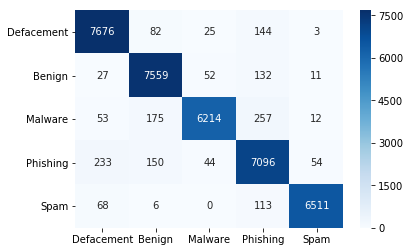

In [28]:
y=LabelEncoder().fit_transform(categorical_df[dep_var].values)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Defacement','Benign','Malware','Phishing','Spam'],
           yticklabels=['Defacement','Benign','Malware','Phishing','Spam'])

#### Graph of Categorical Cross-Entropy Model

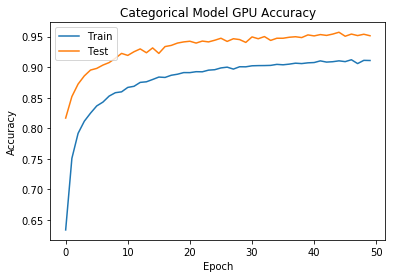

In [29]:
plotAccuracy('Categorical Model GPU Accuracy')

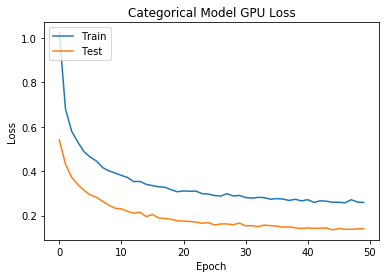

In [30]:
plotLoss('Categorical Model GPU Loss')

### Write results to file

In [0]:
def saveLog():
    resultFile = os.path.join(resultPath, dataFile)
    with open('{}.result'.format(resultFile), 'a') as fout:
        fout.write('{} results...'.format(model_name+model_extension))
        fout.write('\taccuracy: {:.2f} loss: {:.2f} time_elapsed: {} min {} sec\n'.format(acc, loss, Minutes, end_time))

In [0]:
saveLog()

## Binary Classification of Labels
> Change all malicious labels to value 1 and benign label to 0

### Binarize Data

In [0]:
lblTypes = list(lblTypes)
lblTypes = dict(zip(lblTypes, [1, 1, 1, 1, 1]))
lblTypes['benign'] = 0

In [0]:
binary_df = df1.copy()
binary_df[label] = binary_df[label].map(lblTypes)

### Train the Binary Model

In [35]:
model, history, X , encoded_y = experiment(binary_df)

Running fold #1


W0726 23:02:30.175283 140174901987200 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Binary Cross-Entropy Loss Functionwith With GPU
Running fold #2
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #3
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #4
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #5
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #6
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #7
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #8
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #9
Binary Cross-Entropy Loss Functionwith With GPU
Running fold #10
Binary Cross-Entropy Loss Functionwith With GPU
Time to complete 12 min 740.5961241722107 sec


### Model Results

In [36]:
scores = model.evaluate(X,encoded_y, verbose=1)
print(model.metrics_names)
acc, loss = scores[1]*100, scores[0]
print('GPU Baseline: accuracy: {:.2f}%: loss: {:.2f}'.format(acc, loss))

36697/36697 [==============================] - 2s 43us/sample - loss: 0.0356 - acc: 0.9883
['loss', 'acc']
GPU Baseline: accuracy: 98.83%: loss: 0.04


#### Predictions

In [37]:
prediction_y = model.predict_classes(X, batch_size=batch_size, verbose=1)

36697/36697 [==============================] - 1s 29us/sample


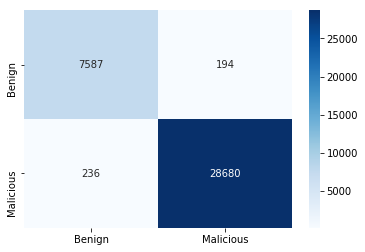

In [38]:
y=LabelEncoder().fit_transform(binary_df[dep_var].values)
cm = confusion_matrix(y, prediction_y)
sn.heatmap(cm, cmap='Blues', annot=True, fmt='g', xticklabels=['Benign', 'Malicious'],
        yticklabels=['Benign', 'Malicious'])

#### Graph of Binary Cross-Entropy Model

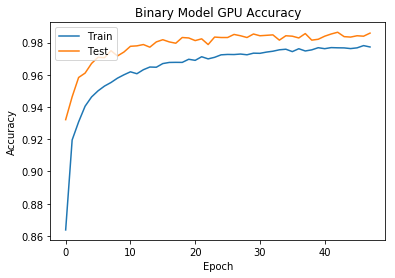

In [39]:
plotAccuracy('Binary Model GPU Accuracy')

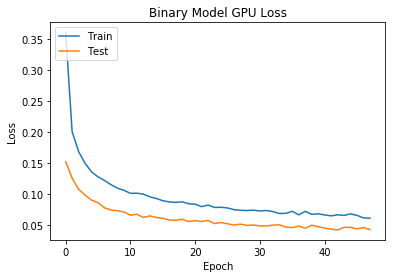

In [40]:
plotLoss('Binary Model GPU Loss')

### Write Results to File

In [0]:
saveLog()